In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
import keras

import pydot
import graphviz
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [3]:
np.random.seed(123)

In [4]:
# Load Data
rnaseq_file = os.path.join('data', 'pancan_scaled_zeroone_rnaseq.tsv')
rnaseq_df = pd.read_table(rnaseq_file, index_col=0)
print(rnaseq_df.shape)
rnaseq_df.head(2)

(10459, 5000)


,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
TCGA-02-0047-01,0.678296,0.289910,0.034230,0.0,0.0,0.084731,0.031863,0.037709,0.746797,0.687833,...,0.440610,0.428782,0.732819,0.634340,0.580662,0.294313,0.458134,0.478219,0.168263,0.638497
TCGA-02-0055-01,0.200633,0.654917,0.181993,0.0,0.0,0.100606,0.050011,0.092586,0.103725,0.140642,...,0.620658,0.363207,0.592269,0.602755,0.610192,0.374569,0.722420,0.271356,0.160465,0.602560


In [5]:
# Split 10% test set randomly
test_set_percent = 0.1
rnaseq_test_df = rnaseq_df.sample(frac=test_set_percent)
rnaseq_train_df = rnaseq_df.drop(rnaseq_test_df.index)

Much of this script is inspired by the [keras variational_autoencoder.py example](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py)

In [6]:
batch_size = 128
original_dim = 5000
intermediate_dim = 1000
intermediate_dim2 = 1000
latent_dim = 300

epochs = 50
epsilon_std = 1.0

In [7]:
# Input place holder for RNAseq data with specific batch size
input_rnaseq = Input(shape=(original_dim, ))

# First batch is compressed into layer size `intermediate_dim` with an ELU activation
first_hidden_layer = Dense(intermediate_dim, activation='elu')(input_rnaseq)
second_hidden_layer = Dense(intermediate_dim2, activation='elu')(first_hidden_layer)

# Hidden layer is compressed again into a mean and log variance vector of size `latent_dim`
z_mean_encoded = Dense(latent_dim)(second_hidden_layer)
z_log_var_encoded = Dense(latent_dim)(second_hidden_layer)

In [8]:
# Function for reparameterization trick to make model differentiable
def sampling(args):
    
    import tensorflow as tf
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z

In [9]:
# return the encoded and randomly sampled z vector
# Takes two keras layers as input to the sampling function
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

In [10]:
# we instantiate these layers separately so as to reuse them later
decoder_to_hidden = Dense(intermediate_dim, activation='elu')
decoder_to_hidden2 = Dense(intermediate_dim2, activation='elu')
decoder_to_reconstruct = Dense(original_dim, activation='sigmoid')
first_output_hidden_layer = decoder_to_hidden(z)
second_output_hidden_layer = decoder_to_hidden2(first_output_hidden_layer)
reconstruct_rnaseq = decoder_to_reconstruct(second_output_hidden_layer)

In [11]:
class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training

    """
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [12]:
vae_loss = CustomVariationalLayer()([input_rnaseq, reconstruct_rnaseq])
vae = Model(input_rnaseq, vae_loss)
vae.compile(optimizer='Adam', loss=None)

/home/gway/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  app.launch_new_instance()


In [13]:
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 5000)          0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1000)          5001000     input_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1000)          1001000     dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 300)           300300      dense_2[0][0]                    
___________________________________________________________________________________________

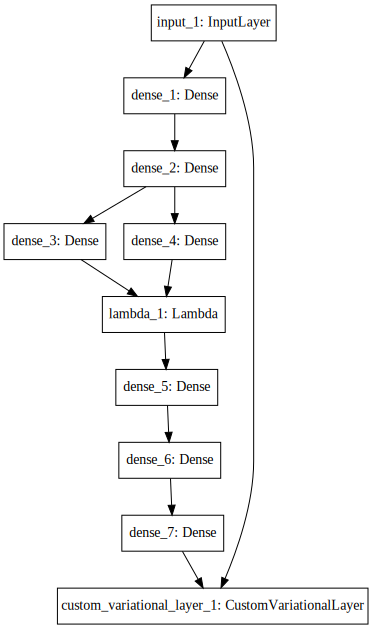

In [14]:
SVG(model_to_dot(vae).create(prog='dot', format='svg'))

In [15]:
output_model_file = os.path.join('models', 'naive_vae.png')
plot_model(vae, to_file=output_model_file)

In [17]:
%%time
hist = vae.fit(np.array(rnaseq_train_df),
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(np.array(rnaseq_test_df), np.array(rnaseq_test_df)))

Train on 9413 samples, validate on 1046 samples
Epoch 1/50
9413/9413 [==============================] - 21s - loss: 3039.1676 - val_loss: 2888.3919
Epoch 2/50
9413/9413 [==============================] - 17s - loss: 2840.6435 - val_loss: 2817.3068
Epoch 3/50
9413/9413 [==============================] - 17s - loss: 2802.0886 - val_loss: 2793.1178
Epoch 4/50
9413/9413 [==============================] - 17s - loss: 2781.4522 - val_loss: 2784.4730
Epoch 5/50
9413/9413 [==============================] - 17s - loss: 2767.1171 - val_loss: 2763.6636
Epoch 6/50
9413/9413 [==============================] - 17s - loss: 2756.6779 - val_loss: 2755.3047
Epoch 7/50
9413/9413 [==============================] - 17s - loss: 2746.3347 - val_loss: 2742.9799
Epoch 8/50
9413/9413 [==============================] - 17s - loss: 2739.9789 - val_loss: 2743.6514
Epoch 9/50
9413/9413 [==============================] - 18s - loss: 2733.3538 - val_loss: 2742.3146
Epoch 10/50
9413/9413 [=============================

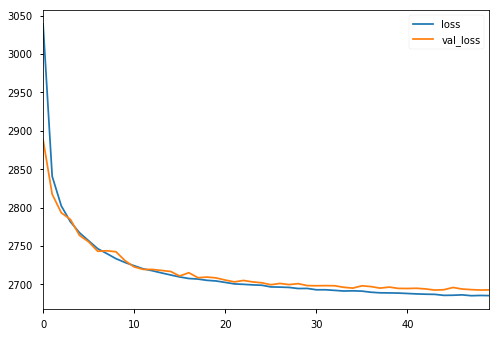

In [18]:
history_df = pd.DataFrame(hist.history)
history_df.plot()

In [19]:
# Model to project input
encoder = Model(input_rnaseq, z_mean_encoded)

In [20]:
# Encode the hidden/latent representation of data
encoded_rnaseq_df = encoder.predict_on_batch(rnaseq_df)
encoded_rnaseq_df = pd.DataFrame(encoded_rnaseq_df, index=rnaseq_df.index)

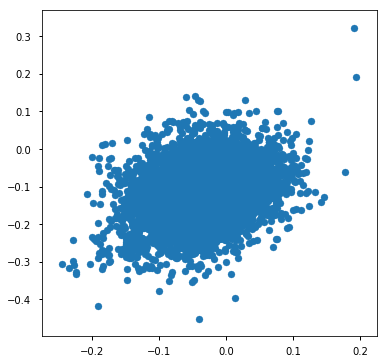

In [21]:
# Example distribution of first two components of latent layer
plt.figure(figsize=(6, 6))
plt.scatter(encoded_rnaseq_df.iloc[:, 0], encoded_rnaseq_df.iloc[:, 1])

In [22]:
vae_output_rnaseq_df = vae.predict_on_batch(rnaseq_df)
vae_output_rnaseq_df = pd.DataFrame(vae_output_rnaseq_df, columns=rnaseq_df.columns, index=rnaseq_df.index)

In [23]:
# Recreate layers separately to use them for decoding and generation purposes later
decoder_to_hidden = Dense(intermediate_dim, activation='elu')
decoder_to_hidden2 = Dense(intermediate_dim2, activation='elu')
decoder_to_reconstruct = Dense(original_dim, activation='sigmoid')
first_output_hidden_layer = decoder_to_hidden(z)
second_output_hidden_layer = decoder_to_hidden2(first_output_hidden_layer)
reconstruct_rnaseq = decoder_to_reconstruct(second_output_hidden_layer)

In [24]:
# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_to_hidden(decoder_input)
_h_decoded2 = decoder_to_hidden2(_h_decoded)
_x_decoded_mean = decoder_to_reconstruct(_h_decoded2)
generator = Model(decoder_input, _x_decoded_mean)

In [25]:
# Here is an example of generated RNAseq data
# It does not appear too heterogeneous - I need to explore better model training
example_z = np.random.sample(size=(10, 300))
generated_rnaseq = generator.predict(example_z)
pd.DataFrame(generated_rnaseq, columns=rnaseq_df.columns)

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
0,0.559747,0.487389,0.529409,0.454713,0.480028,0.526527,0.505835,0.520447,0.529668,0.413571,...,0.516080,0.512842,0.571659,0.467331,0.550437,0.536681,0.527869,0.469643,0.535345,0.514185
1,0.506303,0.543941,0.454494,0.434848,0.480913,0.498573,0.505299,0.521479,0.486798,0.404279,...,0.538986,0.507410,0.547223,0.463780,0.510105,0.598142,0.574261,0.447980,0.548949,0.544102
2,0.522403,0.554016,0.508012,0.367176,0.504805,0.506880,0.555890,0.536774,0.509669,0.431641,...,0.495375,0.543486,0.559238,0.448964,0.495188,0.573905,0.579407,0.455263,0.538632,0.484013
3,0.532148,0.523788,0.494182,0.422182,0.482092,0.507554,0.532660,0.509284,0.535638,0.428952,...,0.469146,0.550931,0.570220,0.511405,0.584772,0.601339,0.561054,0.479890,0.582901,0.471987
4,0.523121,0.510723,0.500301,0.405890,0.512372,0.543616,0.525854,0.473617,0.496309,0.443332,...,0.535044,0.519500,0.580702,0.440249,0.550508,0.569119,0.548038,0.443621,0.548679,0.488281
5,0.523242,0.519996,0.501378,0.415278,0.529235,0.484947,0.540837,0.470204,0.561308,0.438966,...,0.524231,0.456722,0.545996,0.450677,0.531329,0.540302,0.525145,0.402702,0.554331,0.524269
6,0.552279,0.504368,0.480620,0.449743,0.506761,0.478188,0.537694,0.504418,0.549632,0.440050,...,0.559400,0.540553,0.534491,0.404291,0.542721,0.569591,0.506000,0.428764,0.550582,0.534486
7,0.507495,0.561283,0.516048,0.417157,0.481108,0.518836,0.499099,0.434419,0.523595,0.447670,...,0.492319,0.530457,0.567149,0.458931,0.535121,0.610639,0.550313,0.449052,0.563558,0.489623
8,0.552097,0.531735,0.508346,0.432748,0.495526,0.510515,0.551070,0.490830,0.502785,0.470211,...,0.546144,0.515853,0.525741,0.448087,0.488776,0.557607,0.562964,0.437905,0.542613,0.506613
9,0.497256,0.548580,0.475690,0.406171,0.484406,0.488939,0.496552,0.498707,0.539896,0.464000,...,0.544436,0.527354,0.593710,0.467761,0.562628,0.579532,0.565529,0.437402,0.539343,0.516189


In [26]:
# Save models (full VAE, generator, encoder)
vae_model_file = os.path.join('models', 'full_naive_vae.hdf5')
generator_model_file = os.path.join('models', 'generator_naive_vae.hdf5')
encoder_model_file = os.path.join('models', 'encoder_naive_vae.hdf5')

vae.save(vae_model_file)
generator.save(generator_model_file)
encoder.save(encoder_model_file)

In [27]:
# This is how models will be loaded
# VAE loading is giving errors because of `sampling` function
# vae_loading_test = keras.models.load_model(vae_model_file)
generator_loading_test = keras.models.load_model(generator_model_file)
encoder_loading_test = keras.models.load_model(encoder_model_file)

/home/gway/anaconda3/lib/python3.5/site-packages/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [28]:
generator_loading_test.predict(example_z)

array([[ 0.55974722,  0.48738867,  0.52940899, ...,  0.46964324,
         0.53534472,  0.51418453],
       [ 0.50630307,  0.5439412 ,  0.45449367, ...,  0.4479796 ,
         0.54894942,  0.54410249],
       [ 0.52240336,  0.55401641,  0.50801176, ...,  0.45526326,
         0.53863239,  0.48401347],
       ..., 
       [ 0.50749528,  0.56128275,  0.51604843, ...,  0.44905156,
         0.56355786,  0.48962328],
       [ 0.55209708,  0.531735  ,  0.5083459 , ...,  0.43790451,
         0.54261315,  0.50661308],
       [ 0.49725598,  0.54858017,  0.47568986, ...,  0.43740216,
         0.5393427 ,  0.51618886]], dtype=float32)

In [29]:
encoder_loading_test.predict_on_batch(rnaseq_df)

array([[-0.05049688, -0.09602527,  0.06132908, ..., -0.02128641,
         0.09153961,  0.02511708],
       [-0.05750412, -0.14518015,  0.05124643, ..., -0.04800973,
         0.08339893,  0.04771405],
       [ 0.06772383, -0.11841697,  0.11290675, ...,  0.0089923 ,
         0.09262013,  0.01238508],
       ..., 
       [-0.02305611, -0.10590325,  0.13724239, ...,  0.0471242 ,
         0.03147119, -0.08649244],
       [ 0.02214008, -0.12208553,  0.07318554, ..., -0.01841478,
         0.0964148 ,  0.08309712],
       [-0.00092756, -0.08099063,  0.07321595, ..., -0.02461414,
        -0.0366689 , -0.07952253]], dtype=float32)